# Stryde Gradients - first-look data analysis for continuous recordings

This notebook contains basic data visualization and analysis of the data collected with Stryde nodes at KAUST during the Stryde Gradients experiment on Nov 11 2024.

The dataset is acquired as follows:

- <font color='blue'>Receivers</font>

    1 line of 44 pairs of buried receivers, each pair equally spaced by 2m for a total lenght of 86m (and with each sensor in the pair spaced by 15cm)
  
    1 receiver placed next to the 22nd pair, 15cm along the crossline direction
  
    1 receiver placed near (and following) the source

- <font color='red'>Sources</font>

    3 sources on the right side of the receiver line at Point 101, 144, 188

    50/30/30 shots per source

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pylops
import matplotlib.pyplot as plt

from matplotlib.colors import SymLogNorm
from matplotlib.colors import LinearSegmentedColormap
from pylops.signalprocessing import FFT2D

from pystryde.reader import *
from pystryde.preproc import *
from pystryde.cmap import cmaps
from pystryde.visual import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Single-receiver Continous record

2024-11-11 06:02:00 2024-11-11 08:26:00


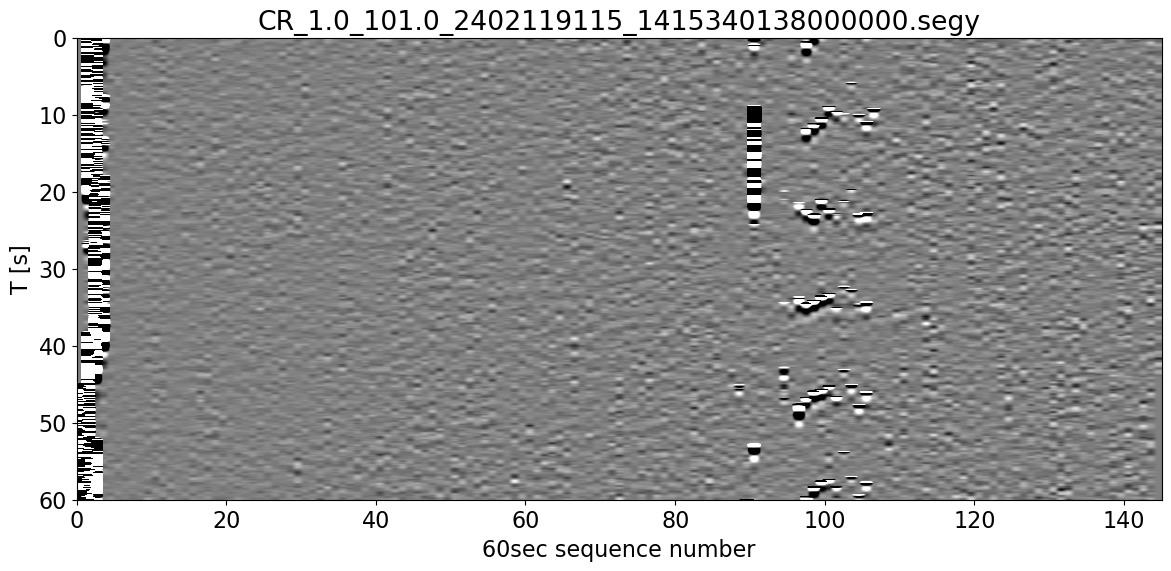

In [2]:
# Early deployment
f = strydecont('/mnt/datawaha_dig/Data/STRYDE/StrydeGradients_11_11_2024/ContinuousRecords/CR_1.0_101.0_2402119115_1415340138000000.segy')
f.interpret()
f.getrecord()
print(f.utctime[0], f.utctime[-1])
f.plotrecord(figsize=(14, 6), title='CR_1.0_101.0_2402119115_1415340138000000.segy', clip=1e-3);

## Entire data Continous record

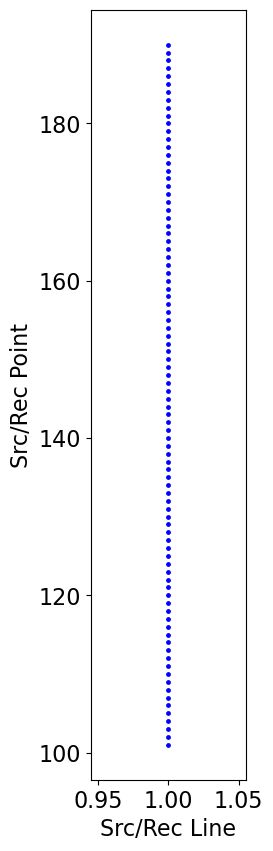

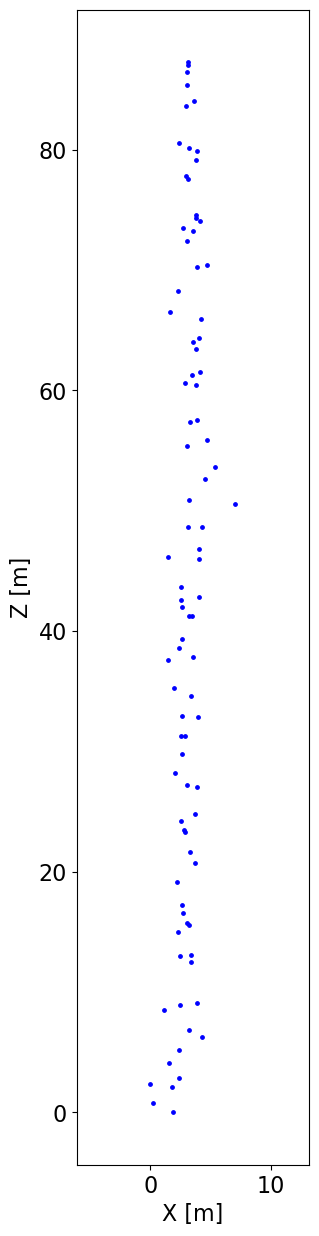

In [3]:
f = strydeconts('/mnt/datawaha_dig/Data/STRYDE/StrydeGradients_11_11_2024/ContinuousRecords/')
f.interpret()
f.plotgeom(coords=False, figsize=(2, 10))
fig, ax = f.plotgeom(local=True, figsize=(3, 15))
ax.axis('equal')

# extract records in a choosen time window
f.getrecords(utctime_start=datetime.datetime(2024, 11, 11, 7, 30), utctime_end=datetime.datetime(2024, 11, 11, 8, 10))

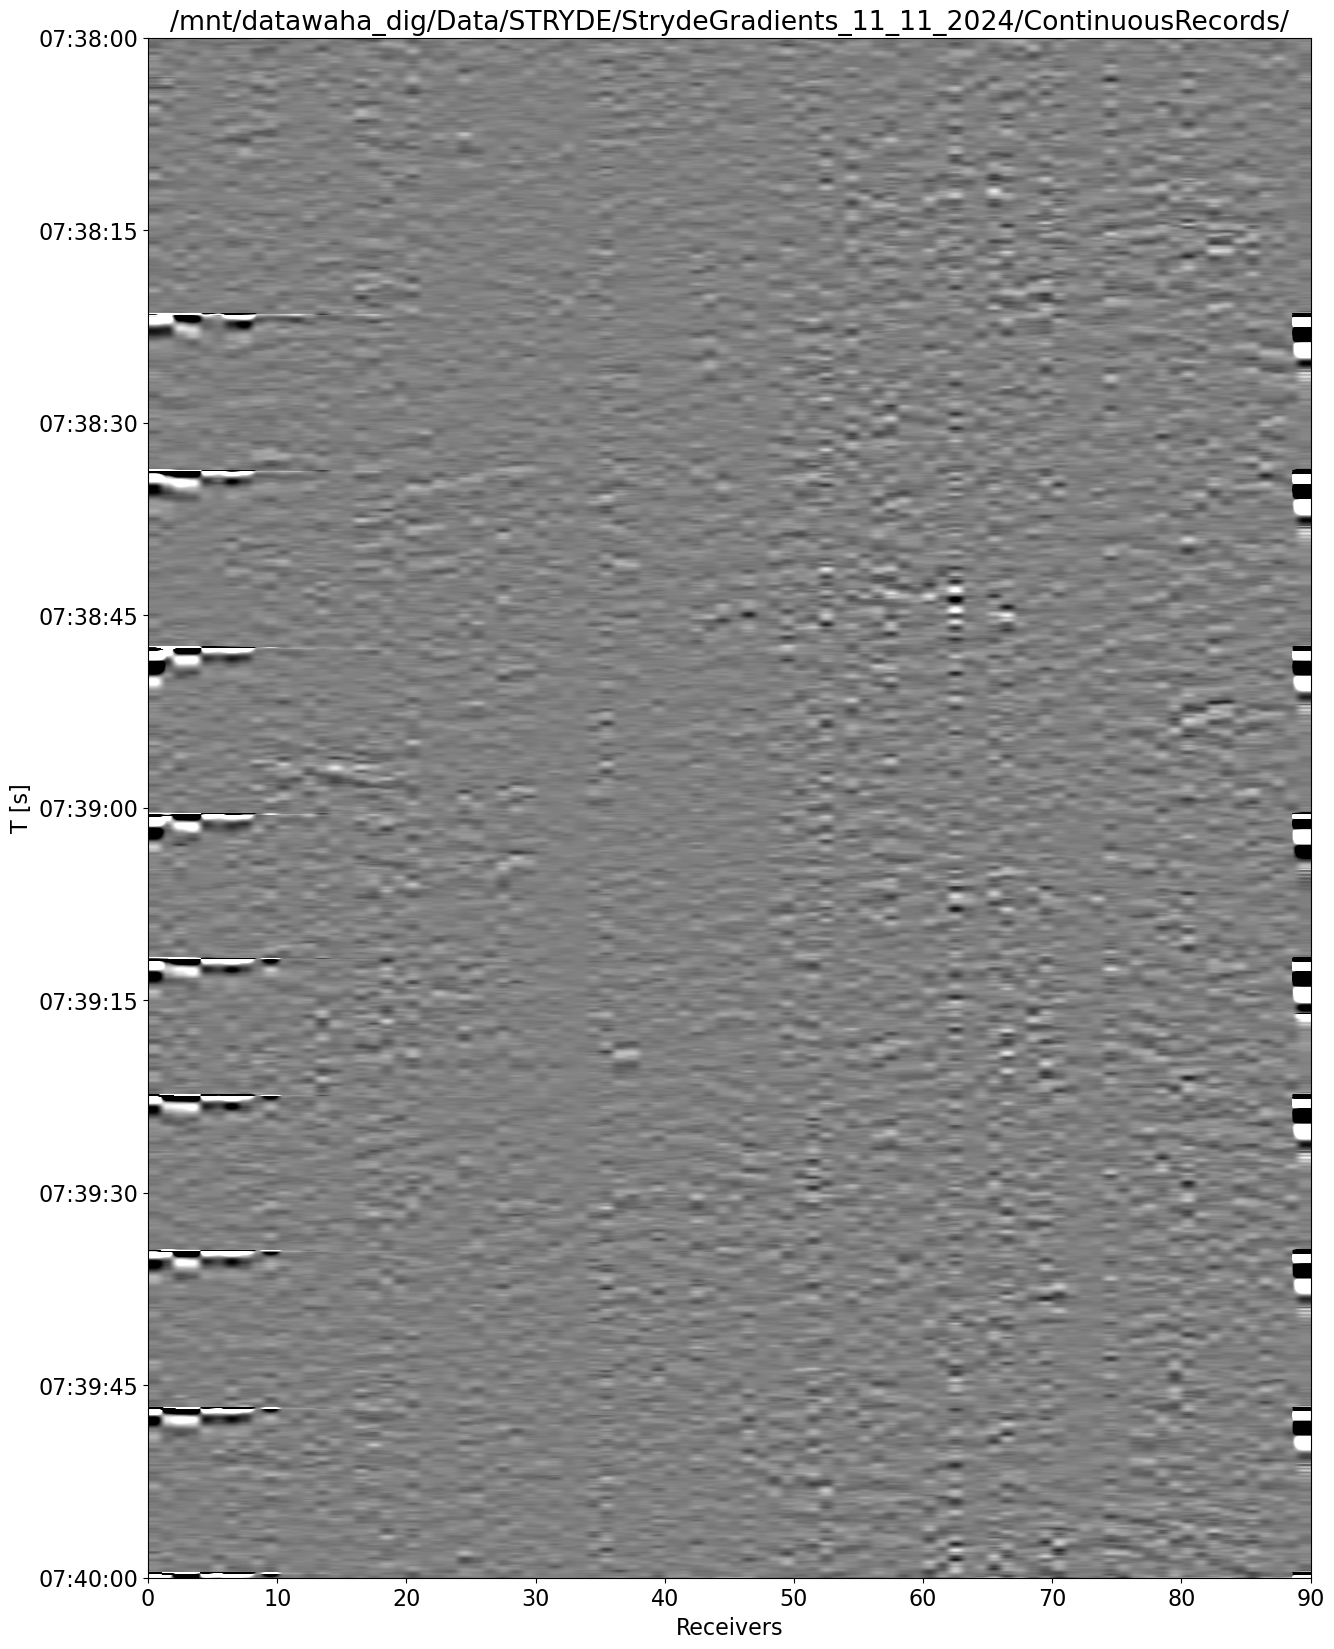

In [4]:
# display continous recording for a given time window multiple of 60sec
f.plotrecord(utctime_start=datetime.datetime(2024, 11, 11, 7, 38),
             utctime_end=datetime.datetime(2024, 11, 11, 7, 40), 
             clip=0.001, cmap='gray', figsize=(15, 20));

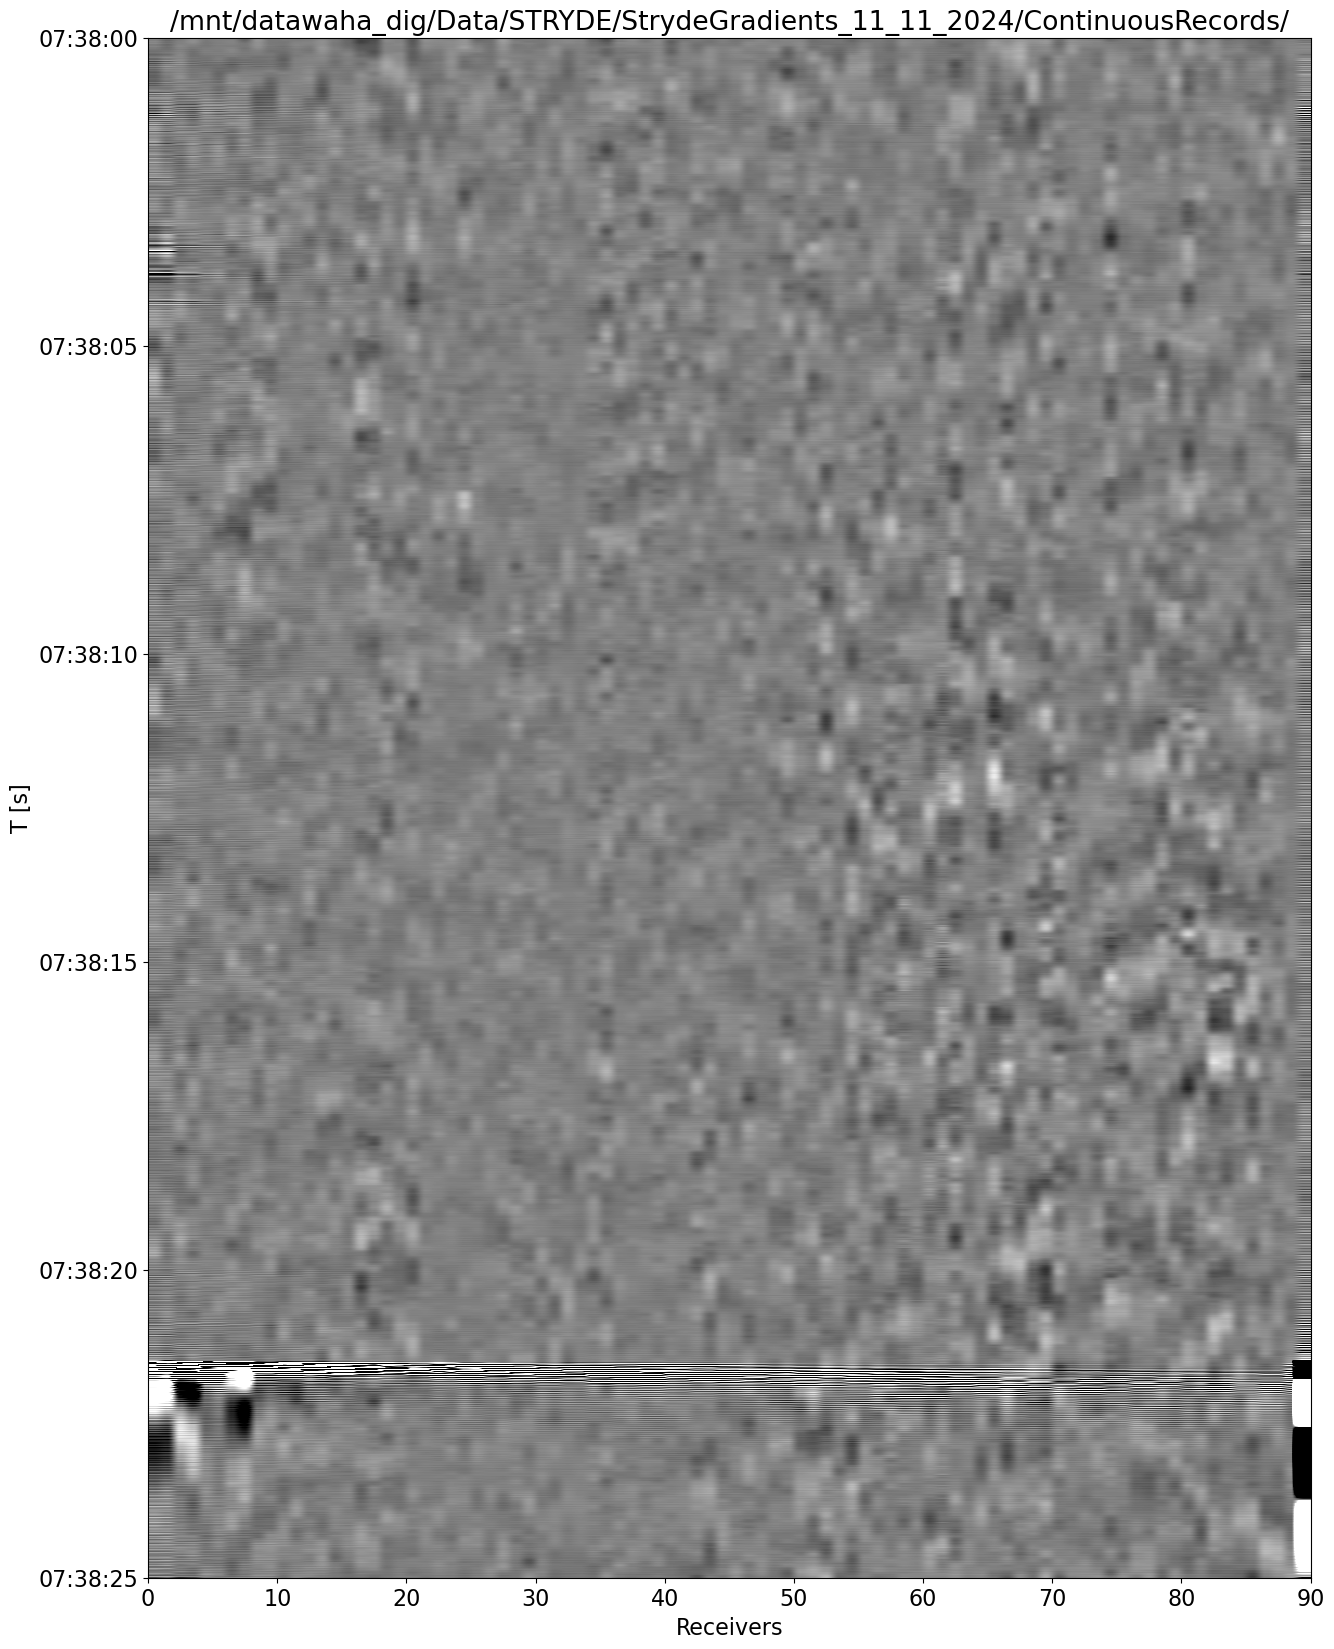

In [5]:
# display continous recording for a given time window (choosing to reduce the end time in terms of samples displayed)
f.plotrecord(utctime_start=datetime.datetime(2024, 11, 11, 7, 38),
             utctime_end=datetime.datetime(2024, 11, 11, 7, 40), 
             nsamples = int(25/f.dt), clip=0.001, cmap='gray', figsize=(15, 20));

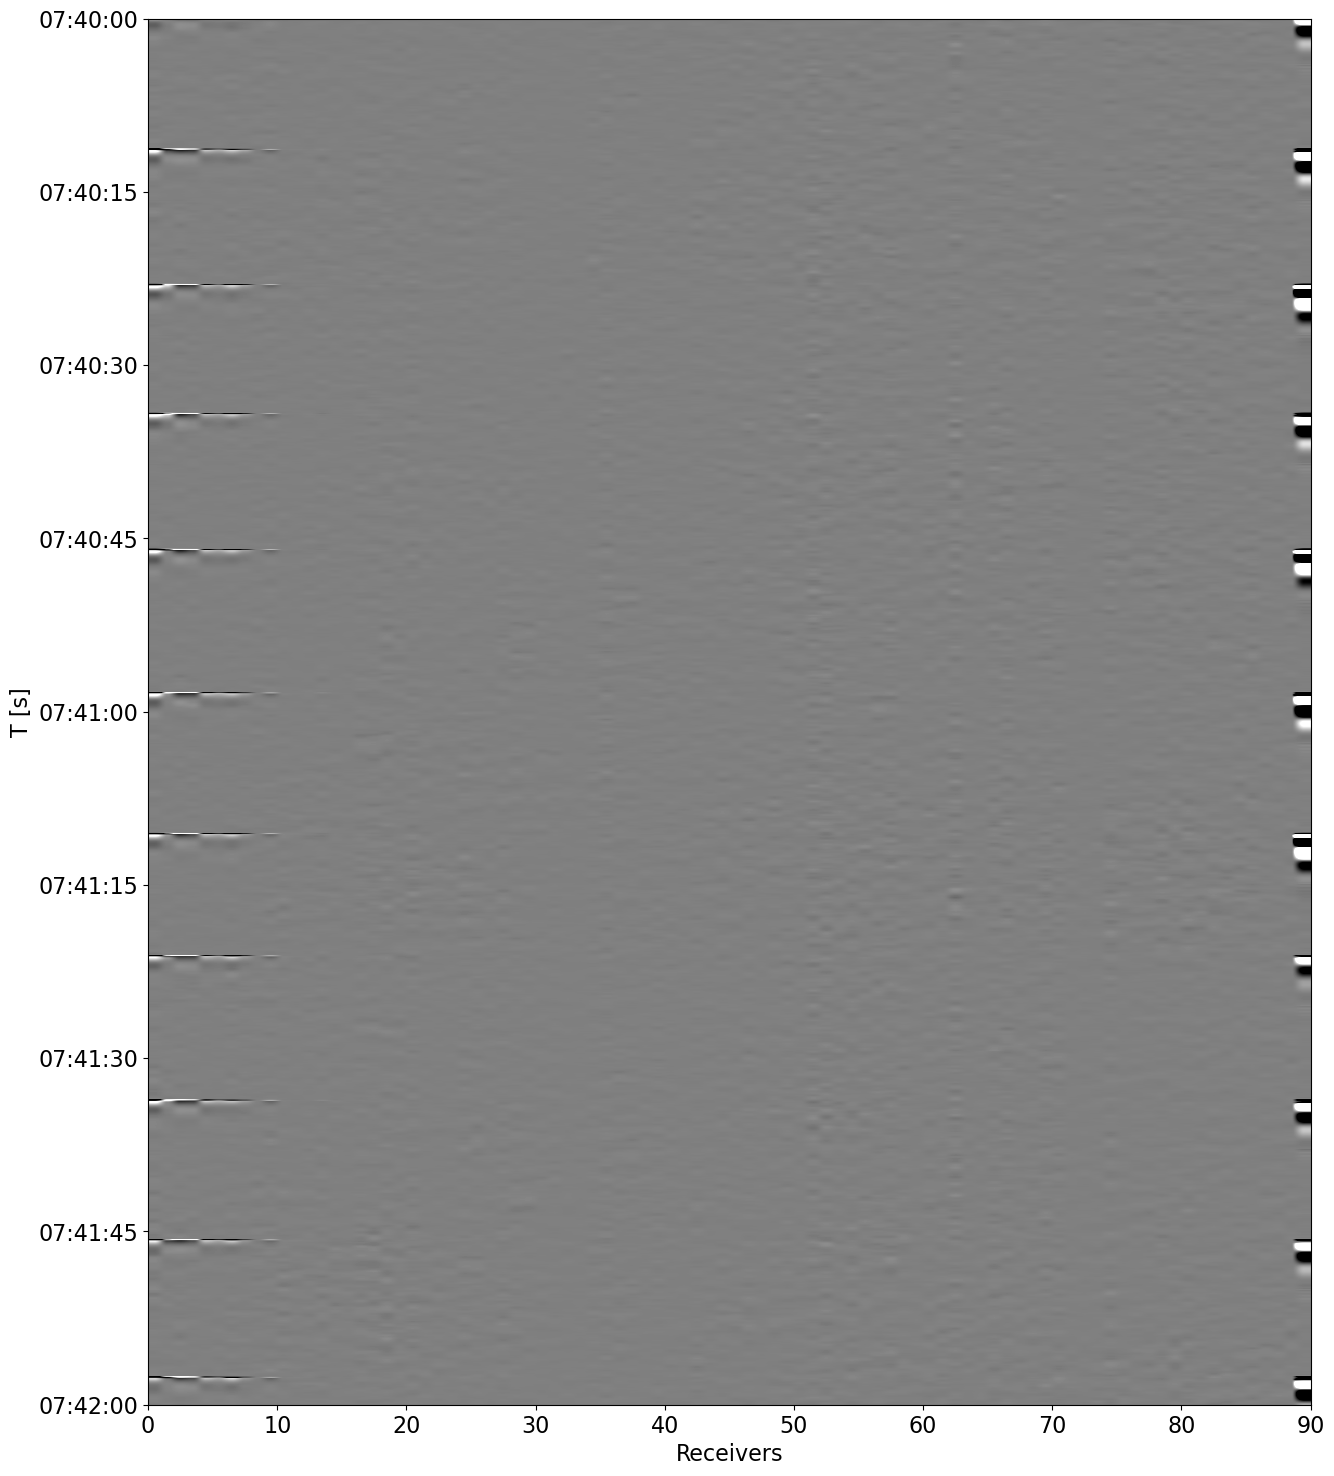

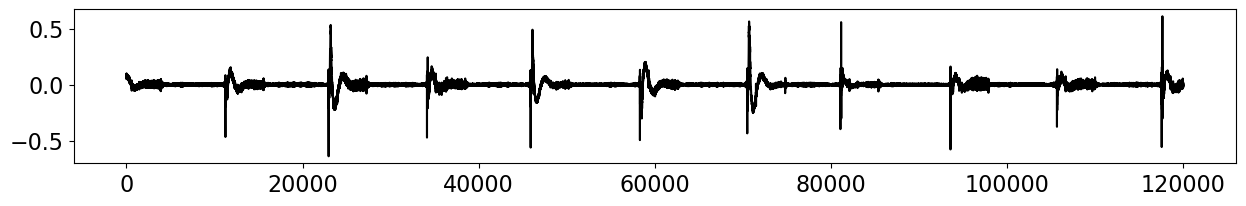

In [6]:
# extact portion of data and display it
data, tlims = f.extract(utctime_start=datetime.datetime(2024, 11, 11, 7, 40),
                        utctime_end=datetime.datetime(2024, 11, 11, 7, 42), 
                        nsamples = int(120/f.dt))

fig, ax = plt.subplots(1, 1, figsize=(15, 18))
ax.imshow(data, cmap='gray', vmin=-0.01, vmax=0.01, extent=(0, f.nrecs, tlims[-1], tlims[0]))
ax.axis('tight')
ax.set_xlabel('Receivers')
ax.set_ylabel('T [s]')
#ax.set_ylim([ tlims[-1], datetime.datetime(2023, 11, 7, 7, 47, 11, 650000)])

plt.figure(figsize=(15, 2))
plt.plot(data[:, -1], 'k');

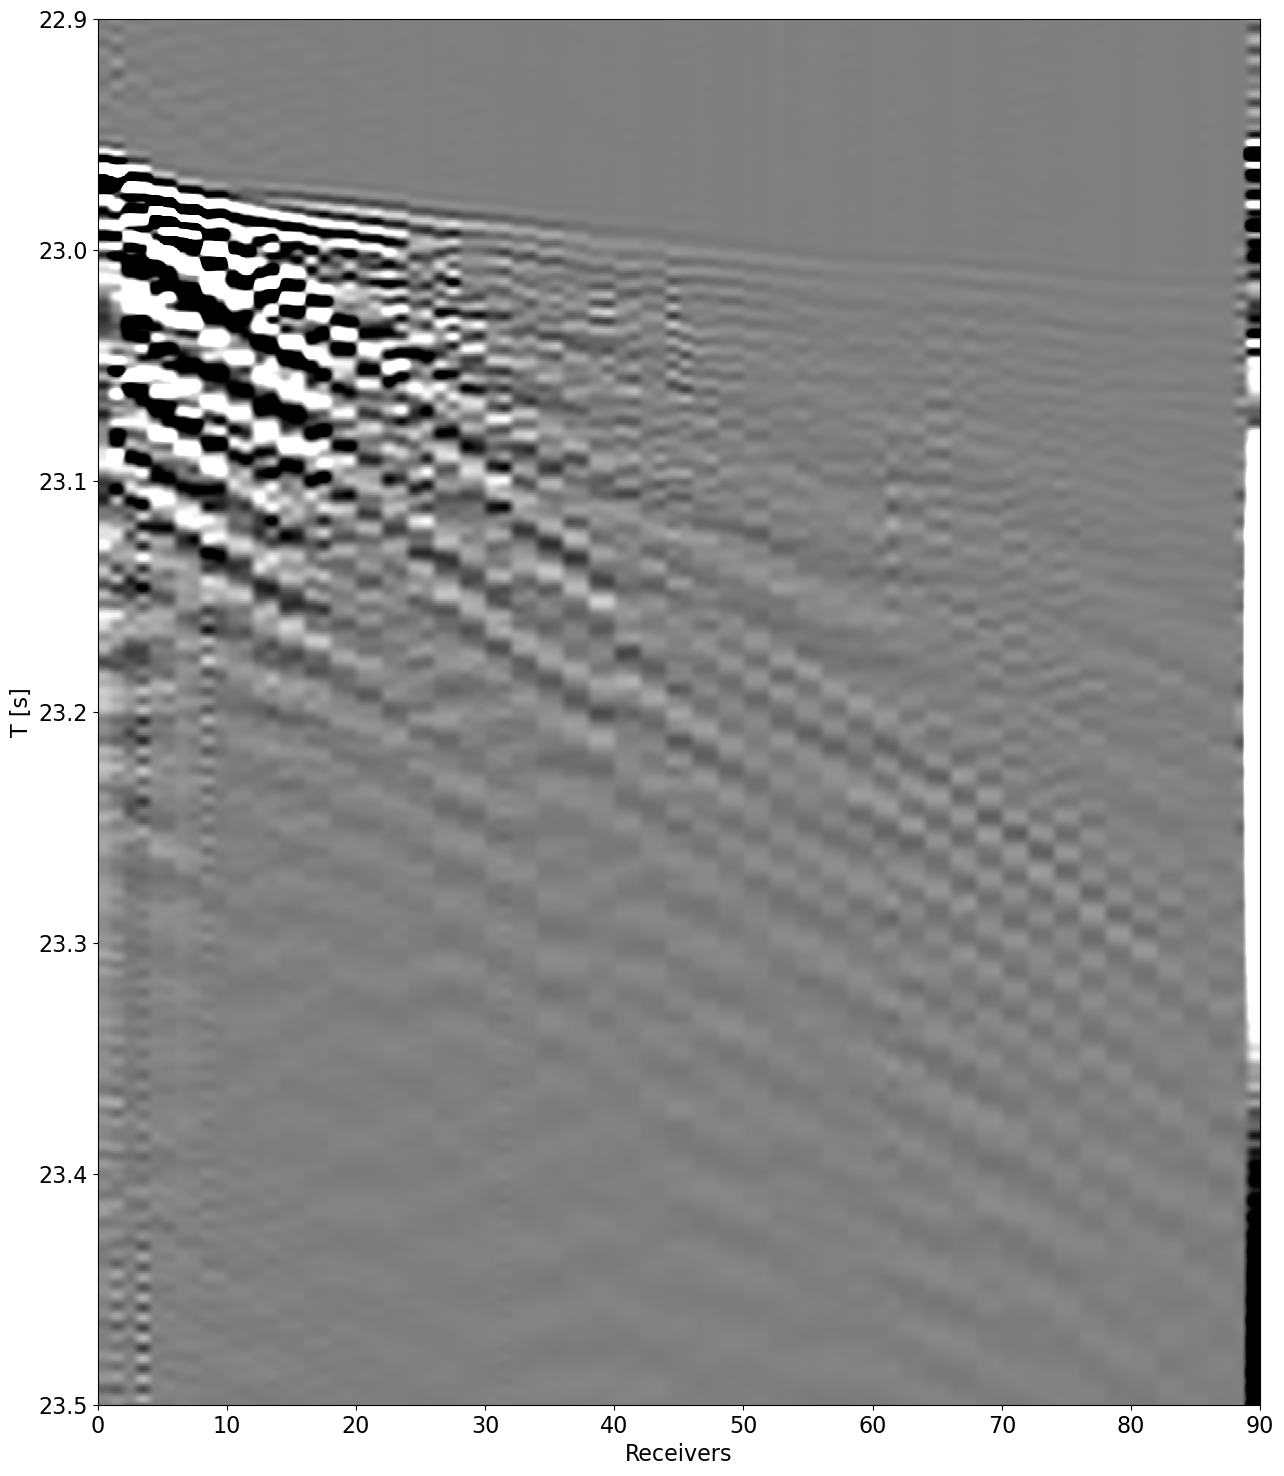

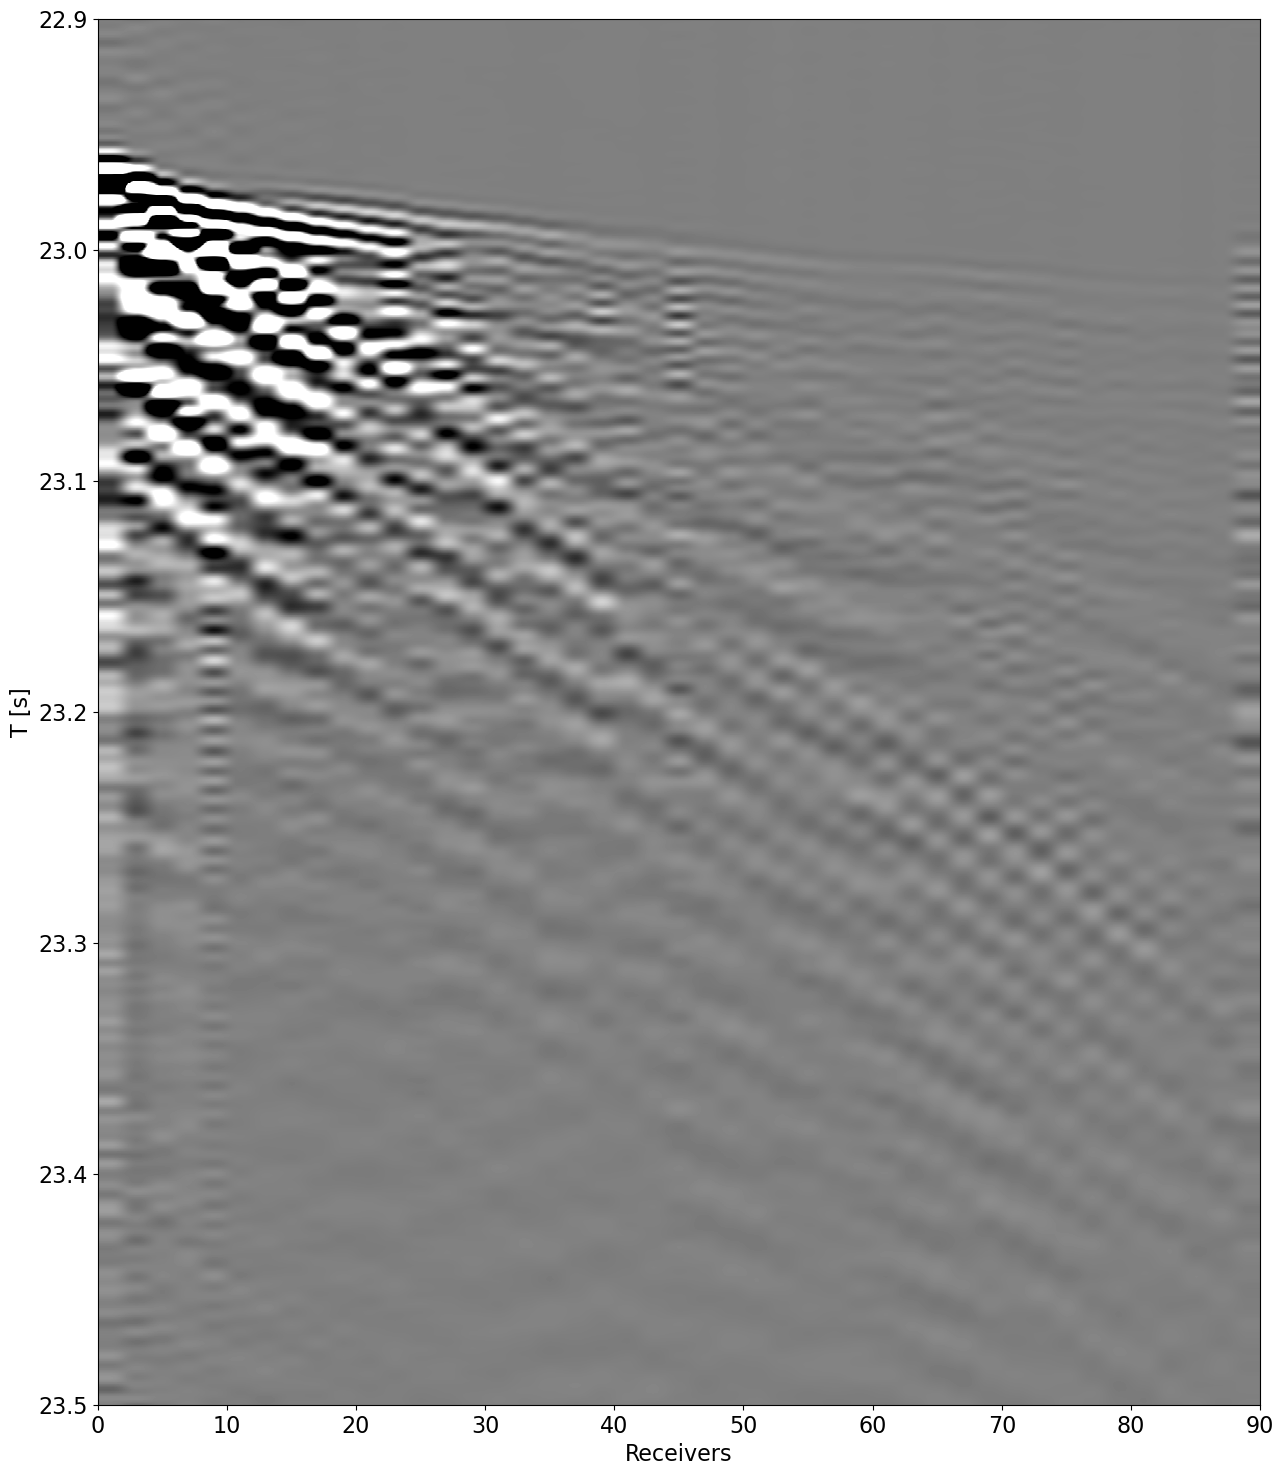

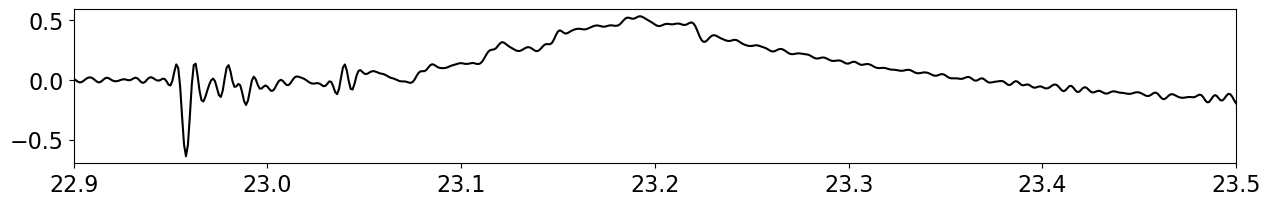

In [7]:
# extact small portion of data near an active shot and display it
data, tlims = f.extract(utctime_start=datetime.datetime(2024, 11, 11, 7, 40),
                        utctime_end=datetime.datetime(2024, 11, 11, 7, 41),
                        nsamples = int(35/f.dt))

fig, ax = plt.subplots(1, 1, figsize=(15, 18))
ax.imshow(data, cmap='gray', vmin=-0.05, vmax=0.05, extent=(0, f.nrecs, f.dt * data.shape[0], 0))
ax.axhline(1.83, color='w')
ax.axis('tight')
ax.set_xlabel('Receivers')
ax.set_ylabel('T [s]')
ax.set_ylim([23.5, 22.9])

plt.figure(figsize=(15, 2))
plt.plot(np.arange(data.shape[0]) * f.dt, data[:, -1], 'k')
plt.xlim([22.9, 23.5])
plt.axvline(1.83, color='k');

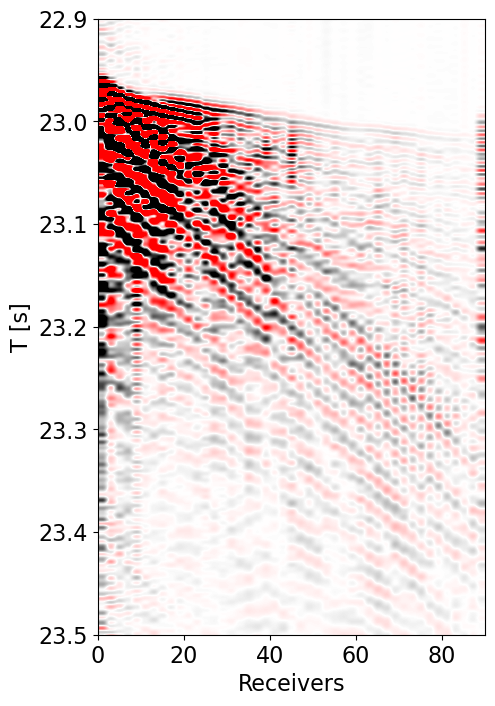

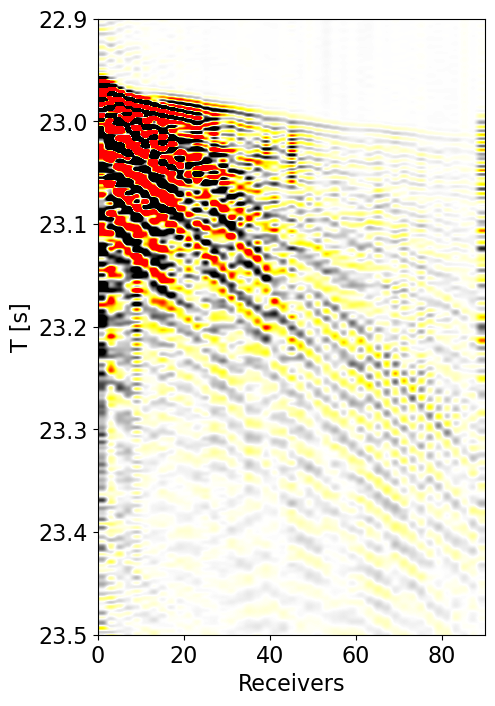

In [12]:
cmap_rbw = \
    LinearSegmentedColormap.from_list('name', ['red', 'white','black'])
cmap_rybgw = \
    LinearSegmentedColormap.from_list('name', ['red', 'yellow','white', 'gray', 'black'])

for cmap in [cmap_rbw, cmap_rybgw]:
    fig, ax = plt.subplots(1, 1, figsize=(5, 8))
    ax.imshow(data[:, ::2], cmap=cmap, vmin=-0.02, vmax=0.02, extent=(0, f.nrecs, f.dt * data.shape[0], 0))
    ax.axhline(1.83, color='w')
    ax.axis('tight')
    ax.set_xlabel('Receivers')
    ax.set_ylabel('T [s]')
    ax.set_ylim([23.5, 22.9])


## Data alignment

### Shot 1

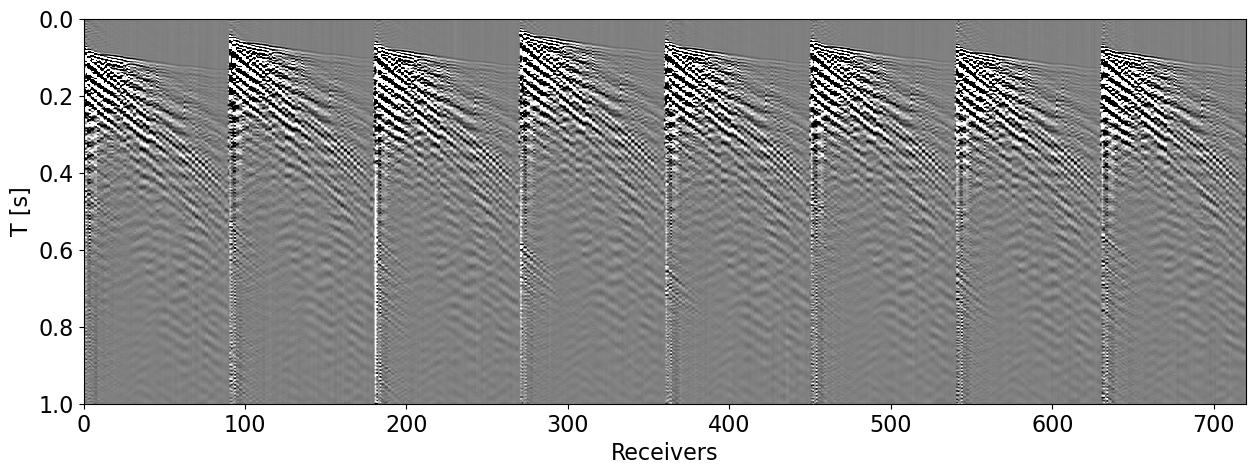

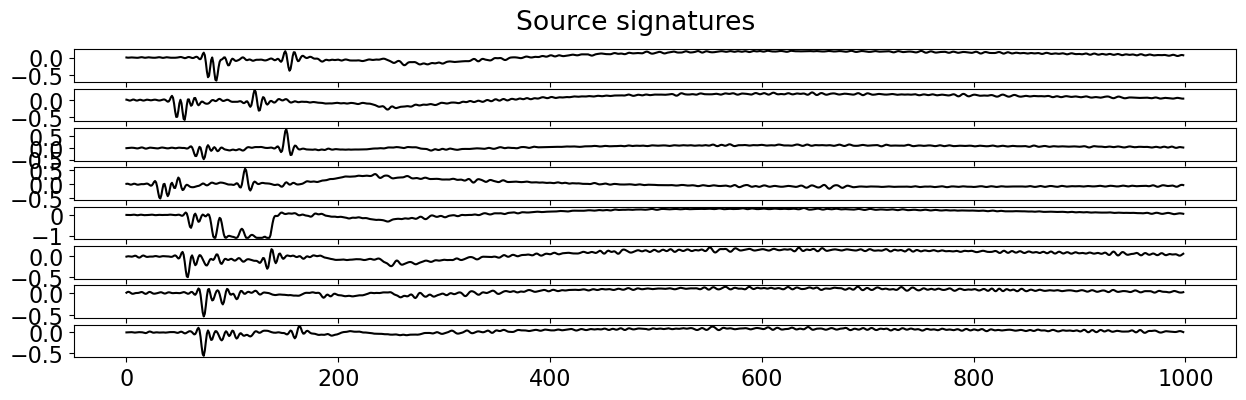

In [39]:
# extract multiple shots and stack them
t0s = [datetime.datetime(2024, 11, 11, 7, 38, 21, 400000),
       datetime.datetime(2024, 11, 11, 7, 38, 33, 650000),
       datetime.datetime(2024, 11, 11, 7, 38, 47, 400000),
       datetime.datetime(2024, 11, 11, 7, 39, 00, 400000),
       datetime.datetime(2024, 11, 11, 7, 39, 11, 650000),
       datetime.datetime(2024, 11, 11, 7, 39, 22, 300000),
       datetime.datetime(2024, 11, 11, 7, 39, 34, 400000),
       datetime.datetime(2024, 11, 11, 7, 39, 46, 660000),
       ]
tmax = 1

datacont, tlims = f.extract(utctime_start=datetime.datetime(2024, 11, 11, 7, 37),
                            utctime_end=datetime.datetime(2024, 11, 11, 7, 40))
sourcesig = []
datas = []
for t0 in t0s:
       dataextract = datacont[int((t0-tlims[0]).total_seconds() // f.dt):, :-1]
       datas.append(dataextract[:int(tmax // f.dt)].T[np.newaxis])
       sourceextract = datacont[int((t0-tlims[0]).total_seconds() // f.dt):, -1]
       sourcesig.append(sourceextract[:int(tmax // f.dt)])

datas = np.concatenate(datas)
sourcesig = np.vstack(sourcesig)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.imshow(datas.reshape(datas.shape[0]*datas.shape[1], -1).T, 
          cmap='gray', vmin=-0.01, vmax=0.01, extent=(0, f.nrecs*len(t0s), tmax, 0))
ax.axis('tight')
ax.set_xlabel('Receivers')
ax.set_ylabel('T [s]');

fig, axs = plt.subplots(len(t0s), figsize=(15, 4))
fig.suptitle('Source signatures')
for iax, ax in enumerate(axs):
    ax.plot(sourcesig[iax], 'k')



Indices of max aligment: [109  91 125  96  99  84  84]
Indices of max aligment after shifts: [109 109 109 109 109 109 109]


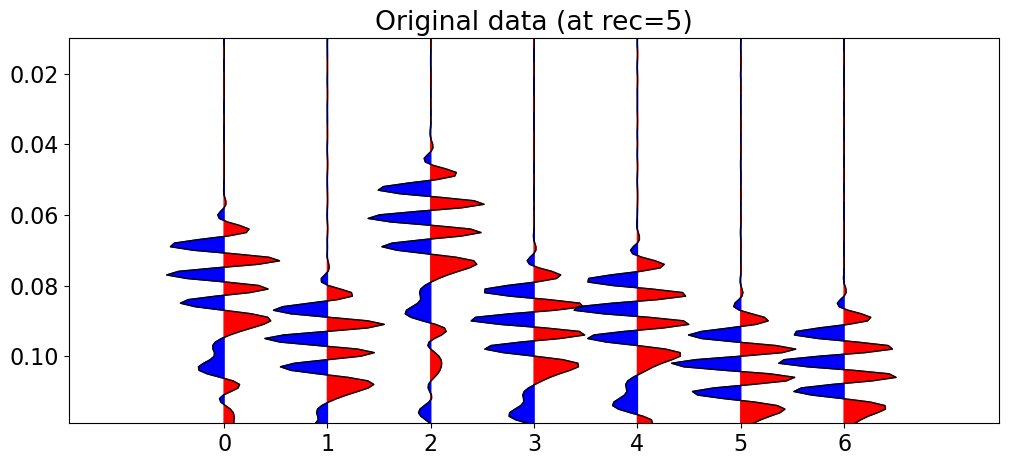

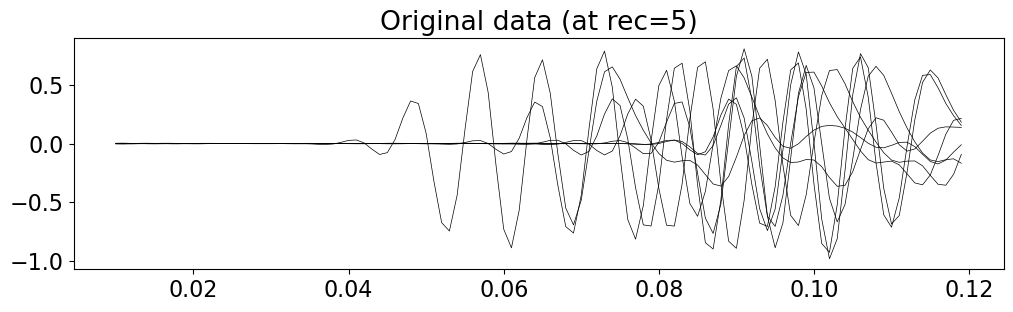

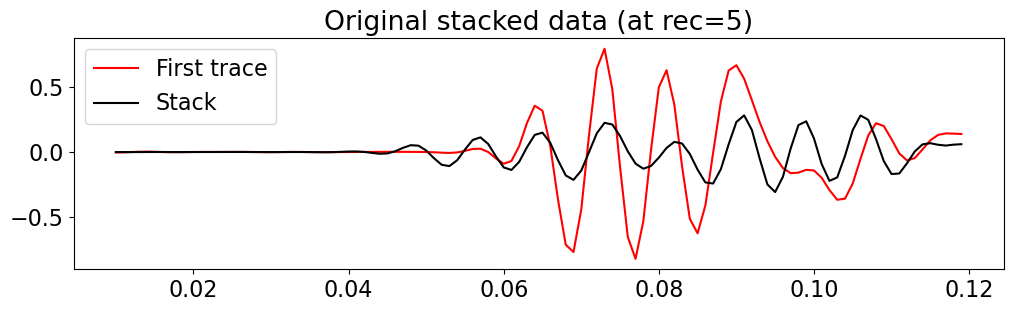

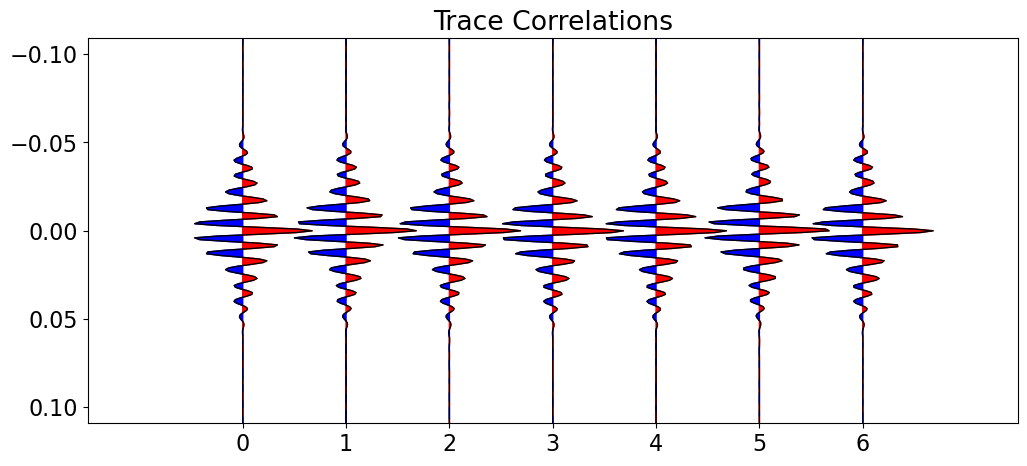

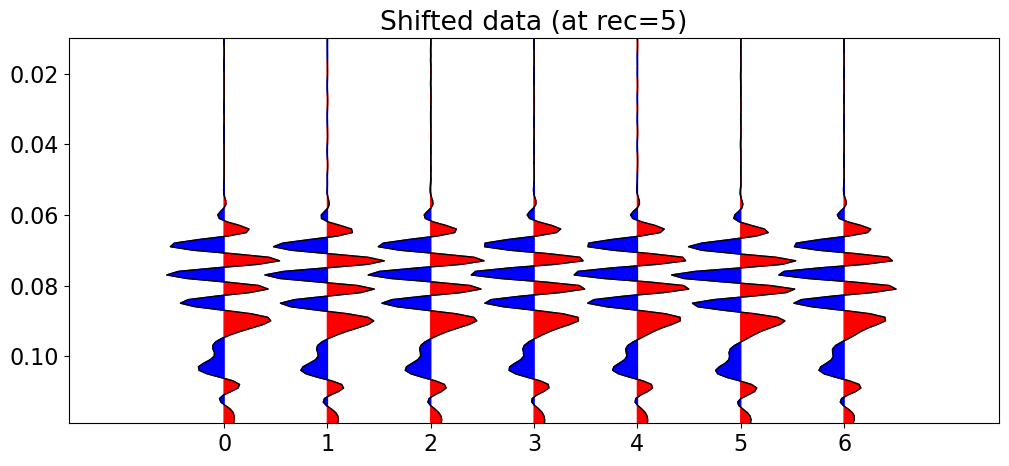

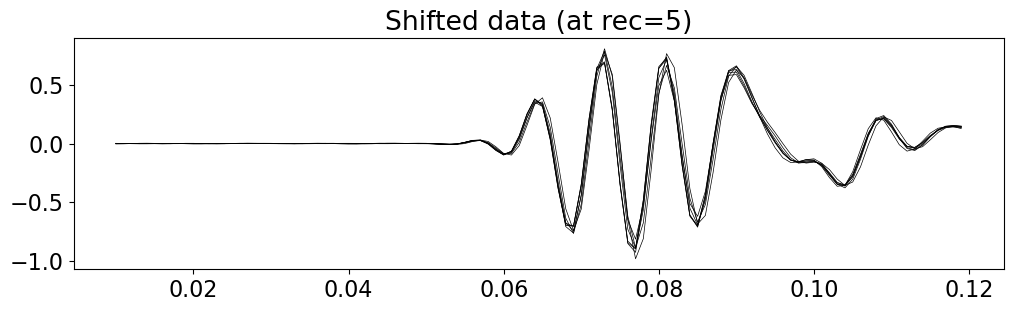

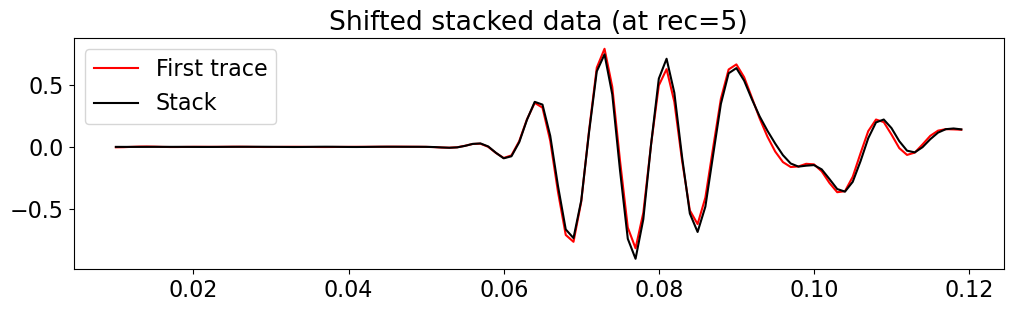

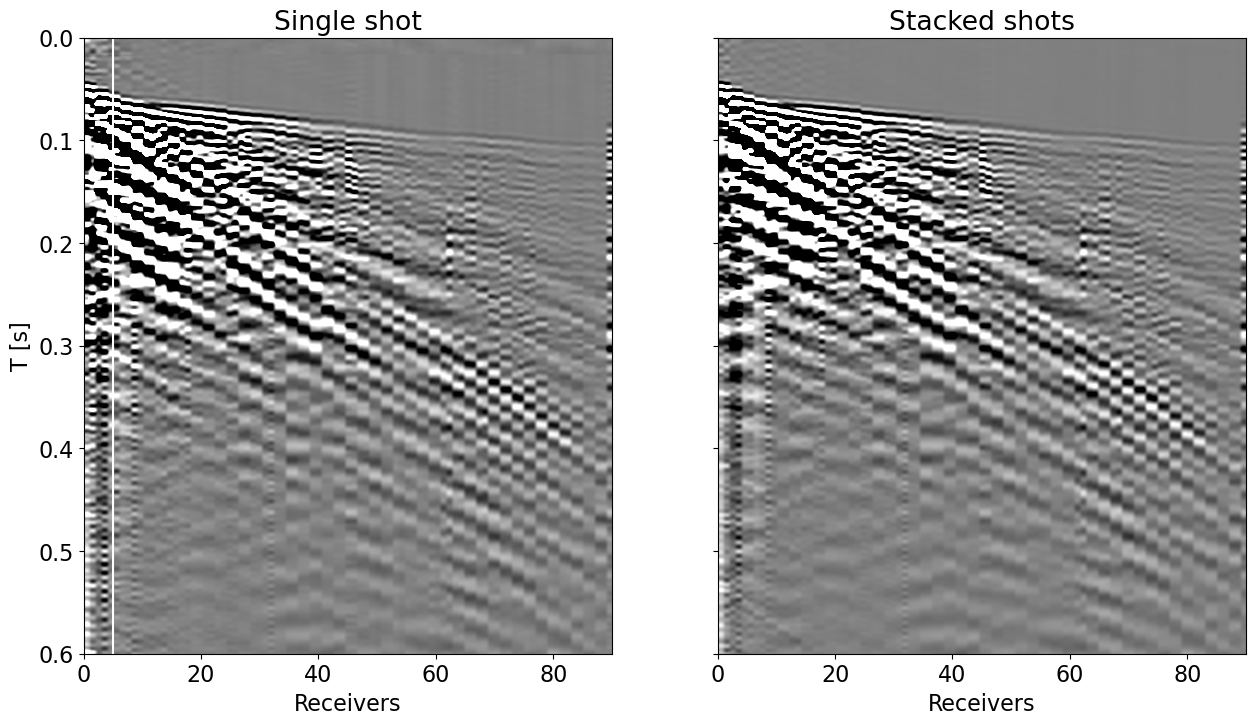

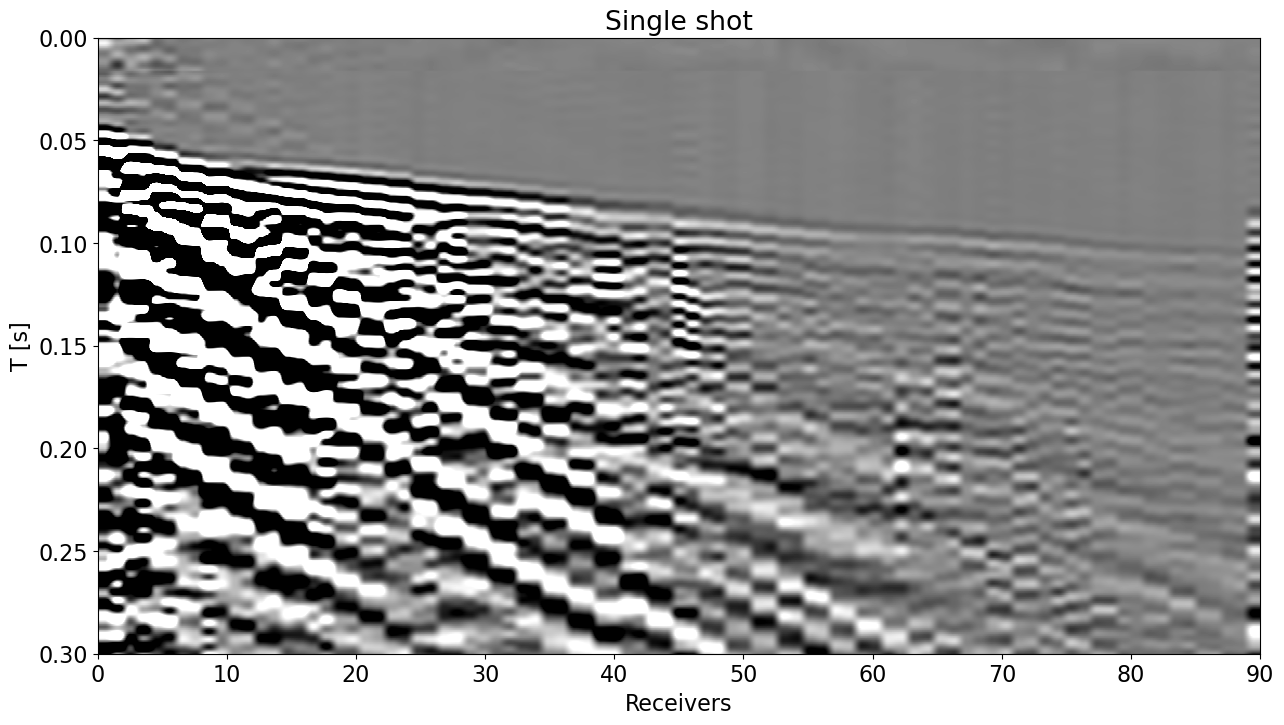

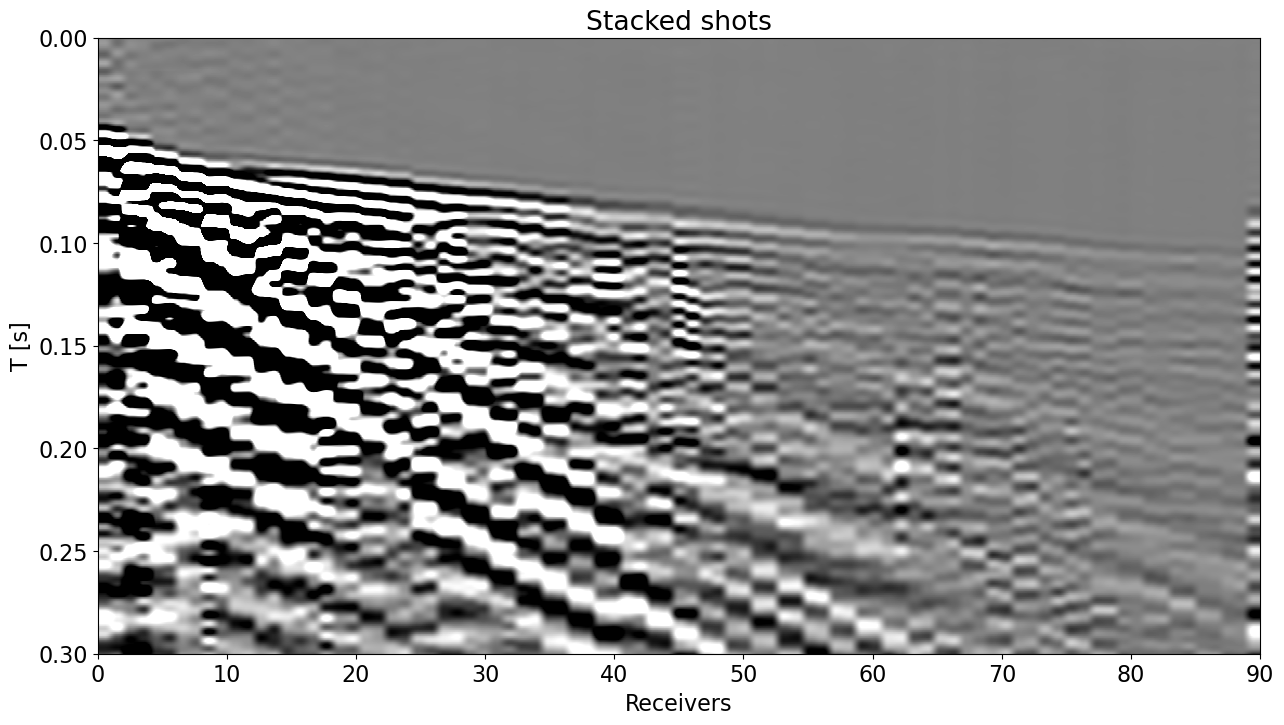

In [42]:
# align data
irec = 5
datashift, figs = aligndata(datas[1:], irec, f.t, tlims=(10, 120), plotflag=True)
dataaligned = np.mean(datashift, axis=0)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 8))
axs[0].imshow(datashift[2].T, cmap='gray', vmin=-0.01, vmax=0.01, extent=(0, f.nrecs, tmax, 0))
axs[0].axvline(irec, color='w')
axs[0].axis('tight')
axs[0].set_xlabel('Receivers')
axs[0].set_ylabel('T [s]')
axs[0].set_title('Single shot')
axs[1].imshow(dataaligned.T, cmap='gray', vmin=-0.01, vmax=0.01, extent=(0, f.nrecs, tmax, 0))
axs[1].axis('tight')
axs[1].set_xlabel('Receivers')
axs[1].set_title('Stacked shots')
axs[1].set_ylim(0.6, 0)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.imshow(datashift[2].T, cmap='gray', vmin=-0.01, vmax=0.01, extent=(0, f.nrecs, tmax, 0))
ax.axis('tight')
ax.set_xlabel('Receivers')
ax.set_ylabel('T [s]')
ax.set_title('Single shot')
ax.set_ylim(0.3, 0);

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.imshow(dataaligned.T, cmap='gray', vmin=-0.01, vmax=0.01, extent=(0, f.nrecs, tmax, 0))
ax.axis('tight')
ax.set_xlabel('Receivers')
ax.set_ylabel('T [s]')
ax.set_title('Stacked shots')
ax.set_ylim(0.3, 0);